
# Feature Engineering

## Overview

- Motivations for feature engineering
- Feature engineering for tabular data:
  - Binning
  - Non-linear transformations
  - Interactions
- Data augmentation for structured data

## Why do we need feature engineering?

### Addressing limitations of linear models

- Linear models (e.g. linear regression) are *linear in parameters*
- Can only automatically capture linear relationships between input features and outputs
  - If the input features have non-linear impacts on the output, these relationships cannot be captured automatically.
- Can only capture the impact of a single feature at a time.
  - Interactions between different features cannot be captured within the model.

However, by manually creating *new features* through feature engineering, we can capture non-linear impacts and interactions that are missed by linear regression ...

...and using *hypothesis testing* we can check if our transformed features improve the predictive power of linear models.

#### House price prediction

What if we suspect that the relationship between house prices and the total floor space is non-linear, such as scaling with the square root of the total floor space? Or what if we believe that an additional $m^2$ of floorspace adds more value to a house in one area than in another?

Modifying our model to test these hypotheses is simple and can provide valuable insights

For instance, instead of using `floorspace` as an input feature, we can use `sqrt_floorspace`. By evaluating the model fit using this modified feature, we can determine if the square root of the floor space is a better predictor of house prices.

Another approach is to interact `floorspace` with `neighbourhood` by calculating a different $\beta_\text{floorspace}$ parameter for each neighbourhood. If the model fit improves significantly, accounting for the additional parameters, then this suggests that this is a better model.

Overall, modifying our model through feature engineering allows us to test hypotheses and improve our understanding of the relationship between input features and outputs.

### Non-linear models

Feature engineering is not just limited to linear models, but can also be beneficial for more complex non-linear models such as neural networks and ensembles.

One reason for this is the issue of *data efficiency*:
 - In practice, we always have a finite amount of data to work with, and this data needs to be used for training, validation, and testing.
 - Therefore, it is essential to make the most effective use of the available data.

By performing feature engineering, we can give our models a "head-start", especially when we have prior knowledge that specific transformations of the data are likely to be effective. 

This kind of pre-processing step is known as *feature engineering* because we make alterations to the input features to improve the efficacy of our model. 

### Data Augmentation

Another related area to feature engineering for data efficiency is *data augmentation*. 

The idea behind data augmentation is to increase the size of the training data by adding noise or other variations to the existing data, thereby making our models more robust.


## Feature engineering in Python

One effective way to illustrate the concepts of feature engineering and data augmentation is by working through an example. To make it more relevant and engaging, let's create a synthetic dataset (so that we know the true data generation process) that describes BBQ sales. Specifically, our dataset consists of one input feature ($x$) that represents the temperature on a given day, and a scalar target ($y$) that represents the number of BBQ sales in a large store on that day.


In [ ]:
import numpy as np
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore", category=FutureWarning)
WIDTH = 750
HEIGHT = 250

# set style of matplotlib plots
sns.set_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 
                        'axes.spines.top': False}) 


# Our data generation process
def generate_data_nonlinear(n):
    np.random.seed(n+2001)
    x = (np.tanh(np.random.randn(n)*0.4)+0.8)*20
    y = 0.02*np.minimum(x, 25) + 1/(1+np.exp(-(x-23)))
    y = np.abs(y*30 + np.random.randn(n)*7 + 3)
    return x, y

# Function to format our plots consistently with correct axis, scale, size, etc 
def setup_bbq_plot(ax=None, xlim=None, ylim=None, title="BBQ sales by temperature"):
    ax = ax if ax is not None else plt.gca()
    ax.set_xlabel("Temperature")
    ax.set_ylabel("Num. sales")
    ax.set_title(title)
    (xlim is not None) and ax.set_xlim(xlim)
    (ylim is not None) and ax.set_ylim(ylim)
    plt.gcf().set_size_inches(8,3.5)

# Function to generate plots of the data and fitted models
def plot_bbq_fit(model, x, y, ax=None, tform=None, xlim=None, 
                 scatter=True, color="#f46d43"):
    ax = ax if ax is not None else plt.gca()
    scatter and ax.scatter(x, y, alpha=0.5)
    xlim = xlim if xlim is not None else (0,33)
    line_xs = np.linspace(*xlim, 100)
    if not isinstance(model, np.ndarray):
        if tform is None:
            X_pred = np.stack((np.ones(100), line_xs, line_xs > 22)).T
        else:
            X_pred = tform(line_xs)
        line_ys = model.predict(X_pred)
    else:
        line_ys = model
    ax.plot(line_xs, line_ys, c=color);
    setup_bbq_plot(ax)

In [ ]:

x, y = generate_data_nonlinear(100)
plt.scatter(x, y, alpha=0.5); setup_bbq_plot()

In our BBQ sales example, it's clear that there is a non-linear relationship between the input feature (temperature) and the output target (number of BBQ sales). Specifically, the relationship may be linear up to a certain point, after which it becomes steeper.

To account for this non-linear relationship, we can break down the problem into a sequence of linear models. Instead of fitting a single linear model to the entire dataset, we can fit multiple linear models to different subsets of the data, each of which captures a different segment of the non-linear relationship.

For example, we can fit a linear model to the data for temperatures below a certain threshold, and another linear model to the data for temperatures above that threshold. 

### Nonlinear relationships

* Q: Can linear regression be extended to model **nonlinear** relationships?
* A: Yes, by applying transformations to the input data.


### Nonlinear relationships

- A linear regression defines a model that must be **linear in parameters** $\color{#07B3AD}{\beta_0, \beta_1, \ldots, \beta_d}$:

$$
y = \color{#07B3AD}{\theta_0} \color{#41658B}{x_0} + \color{#07B3AD}{\beta_1} \color{#41658B}{x_1} + ... + \color{#07B3AD}{\beta_d} \color{#41658B}{x_d}$$

- But the features $\color{#41658B}{x_0, x_1, \ldots, x_d}$ can be absolutely **anything**, including arbitrary nonlinear transformations of the underlying variables

As we know, linear regression models are limited in that they can only represent linear transformations of the input features. However, it's important to recognize that the input features themselves can be anything - including non-linear transformations of the original inputs.

### Nonlinear relationships - manually creating new features

- We may have prior knowledge or a hypothesis about a particular effect that we believe is present in the data. In these cases, we can use this knowledge to manually create new features that capture these relationships.
- We can create new features that encode this relationship. 
- For example, for the BBQ data, we can define features $\color{#41658B}{x_1, x_2}$ as (1) temperature and (2) a threshold of temperature >22 degrees

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.linspace(0,33,2), np.linspace(0,33,2), label="$x_1$")
plt.plot(np.linspace(0,33,200), 30*(np.linspace(0,33,200)>22), label="$x_2$")
plt.legend(); setup_bbq_plot()

For example, imagine we transform the input features by a step function that has some temperature threshold and append this as an extra dimension to the input. 

Now the two input features are (a) temperature and (b) the thresholded temperature. 


### Nonlinear relationships

- The model fit using these features is shown below

In [ ]:
from sklearn.linear_model import LinearRegression

X = np.stack((np.ones(100), x, x > 22)).T
model = LinearRegression().fit(X, y)
plot_bbq_fit(model, x, y)

The model fit using this model can be seen in this picture - this is a much better model of reality and is a good illustration of how we can make non-linear models by pre-processing the input features to linear regression. 

### Binning

A more general approach to turn a continuous feature into one or more discrete features is *binning*
* E.g. young/middle-aged/elderly categories to predict employment
* `sklearn.preprocessing`:
    * [`KBinsDiscretizer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html#sklearn.preprocessing.KBinsDiscretizer): splits the data into specified bins
    * Quantile: each bin with equal number of items (bins can have different ranges)
    * Uniform: all bins have the same range
    * kmeans: Bins contain the nearest neighbours from clustering

Binning essentially places a range of continuous values into discrete bins. For example, turning ages into a young/middle-aged/elderly categories.

For models like linear regression, putting continuous features into bins can improve performance, allowing for a nonlinear relation between input and output.

### Sinusoids

- Using sinusoids to model the BBQ data:

In [ ]:
def sinusoids(x, start=0, num=4):
    out = np.ones((1, len(x)))
    for i in range(start, start+num+1):
        out = np.concatenate((out, np.stack((np.cos(2**(-i) * x), np.cos(2**(-i) * x)))))
    return out.T

X = sinusoids(x)
model = LinearRegression(fit_intercept=False).fit(X, y)
plot_bbq_fit(model, x, y, tform=sinusoids, xlim=(-5,40))

We can transform the input data using mathematical functions.
* This is not about changing the model itself, but about modifying the input data to better capture the nonlinear patterns in the data.
* For instance, consider the simple sinusoid function as an example. We can transform the input variable $x$ using the cosine function and fit a linear regression model on the transformed data.
* The resulting model captures a periodic pattern, which might be useful if the data has a similar pattern. For instance, if we have yearly data, we might want to fit a periodic function that predicts higher values in summers and lower values in winters.

### Bounded functions

- Alternatively one can use bounded functions
- Consider the following eight 'bump' functions:

In [ ]:
def bumps(x, centers=np.linspace(3,30,8)):
    out = np.ones((1, len(x)))
    for c in centers:
        out = np.concatenate((out, sqexp(x - c).reshape(1,-1)))
    return out.T

sqexp = lambda x: np.exp(-x**2/4)

centers = np.linspace(3,30,8)
features = bumps(np.linspace(-5,40,200), centers=centers)
plt.plot(np.linspace(-5,40,200), features[:, 1:])
setup_bbq_plot(xlim=(-5,40), ylim=(0,3), title="")

Another way to capture nonlinear relationships between inputs and targets is to use "bump" functions. These are simple functions that are active in a small region of the input space and vanish beyond a certain subset of the input space, allowing us to put emphasis on certain parts of the input space.

For instance, we can apply bump functions to model the BBQ sales data. By attaching bumps to the input features, we obtain a fit that emphasizes certain temperature ranges where sales are higher. However, the resulting model is overfitting in a sense, as it predicts sales to drop off beyond our data, which may not be appropriate for this specific case. Nevertheless, this illustrates how bump functions can be used to capture nonlinear relationships in data.

In [ ]:
X = bumps(x)
model = LinearRegression(fit_intercept=False).fit(X, y)
plot_bbq_fit(model, x, y, tform=bumps, xlim=(-5,40))

We can investigate exactly what this model is doing by splitting up the various bump function fits.

The orange line represents the linear combination of all of these inputs for each input location in $x$. 

In [ ]:
_line_xs = np.linspace(-5, 40, 100)
_line_ys = bumps(_line_xs) * model.coef_
plot_bbq_fit(model, x, y, tform=bumps, xlim=(-5,40))
plt.plot(_line_xs, _line_ys[:,1:]);

- The regression line (<span style="color:#f46d43">orange</span>) is a linear combination of the features supplied
- The plot also shows the individual components that make up this line.

### An automated approach

Manually creating features can be very laborious.

Fortunately, `scikit-learn` provides a number of tools for feature engineering.

- One can use combinations of standard nonlinear functions e.g.:
    - Polynomials: $x, x^2, x^3, x^4, \ldots$
       - See [`sklearn.preprocessing.PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures)
    - Sinusoids: $\cos(x), \sin(x), \cos(2x), \sin(2x), \ldots$ (Fourier basis) 
       - See [`sklearn.preprocessing.FunctionTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html#sklearn.preprocessing.FunctionTransformer)
- These functions have **global** impact, i.e. they impact the model fit **everywhere**
    - Use [piecewise polynomials (splines)](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.SplineTransformer.html#sklearn.preprocessing.SplineTransformer) to have different impacts in different parts of input space

There are several popular methods for performing non-linear regression, but in practice, you may need to try multiple methods and choose the one with the best $R^2$ fit for your data. Here are a few examples:

* Polynomial regression involves using a polynomial transformation of the features to fit an arbitrary order polynomials to the data.
* Fourier basis functions can be used to transform the data and model periodicity, particularly for time series data.
* Splines involve dividing the input space into segments and applying piecewise polynomials to the inputs, which can be useful when there are abrupt changes in the relationship between the features and the target variable.

There are many other methods available, but these are just a few examples. It's important to choose a method that makes sense for your data and the underlying relationship between the features and the target variable.

### Feature tuning

- There are a variety of parameters associated with such features:
    - Number of functions, centres, width, frequency, etc.
- These parameters can be optionally tuned during the linear regression fitting process.
- Alternatively, they can be **handcrafted**, or tuned with **cross-validation**.

When designing feature transformations, it is important to consider various design decisions and cross-validate the models to avoid overfitting to the training/test data. 

It is essential to remember that the feature transformation functions do not tune the parameters during linear regression. Instead, they transform the input features, and linear regression is performed on these transformed features.

## Data augmentation strategies 

One effective approach to improve your model's performance is to increase the amount of data available for training. One way to achieve this is through data augmentation, which involves generating additional samples by introducing variations into the original data.

There are several techniques for data augmentation, including:

* Injecting noise into the data to create variations
* Creating permuted samples to expand the training set

By augmenting the data, you can improve the model's accuracy and reduce the risk of overfitting to the training data.

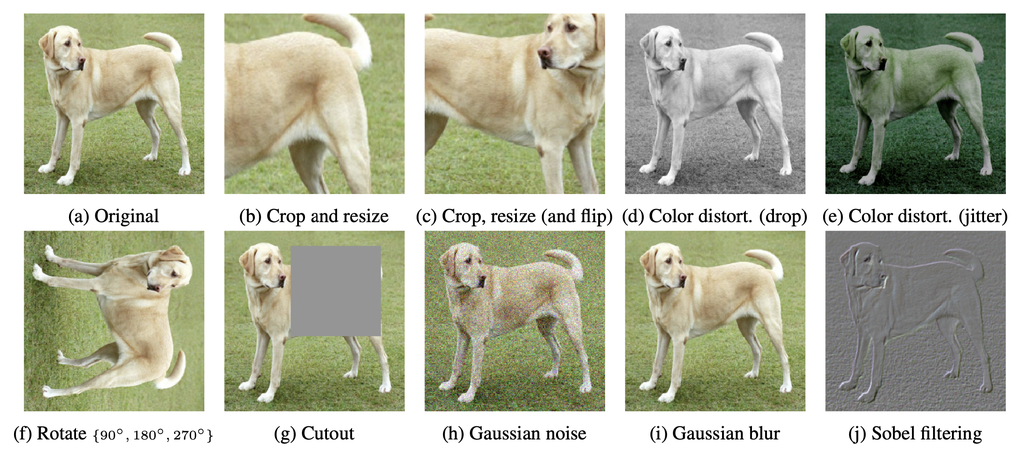

## Data augmentation strategies 

- The same can be done on tabular data using techniques like SMOTE
- New data entries are generated following various strategies as demonstrated below:
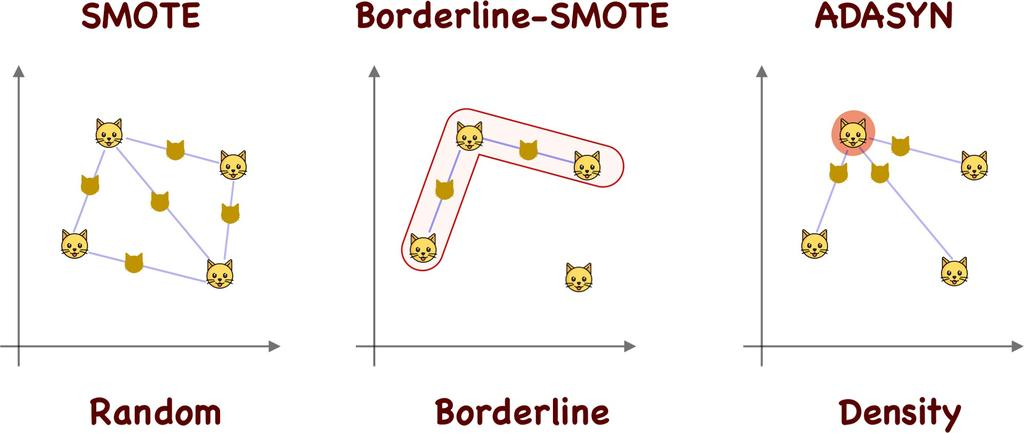

Before fitting a model to your data, it's common to apply a pre-processing step to inject noise into the training data to prevent overfitting. If a model is presented with the same image repeatedly, it may overfit and memorize specific features of that image. Injecting noise by showing slightly perturbed images each time can prevent this issue.

This technique has been particularly effective for neural networks and other models that aim to learn feature extraction automatically.

A recent trend in this area is "contrastive learning," which involves unsupervised pre-training. Instead of immediately fitting the model to the training data and labels, the model first learns to classify whether two images are permutations of the same image or different images. For instance, instead of labeling an image as "dog," the label may be "same dog, rotated 90 degrees" or "different image." By starting from a strong baseline, the model is better equipped to fit to the training data.

## Jupyter Exercise

You can now start working on the `nonlinear-relationships.ipynb` in `practicals`